In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt

# Shows plots in jupyter notebook
%matplotlib inline

# Set plot style
sns.set(color_codes=True)

---
##  Loading data

In [4]:
df = pd.read_csv('./clean_data_after_eda.csv')
df["date_activ"] = pd.to_datetime(df["date_activ"], format='%Y-%m-%d')
df["date_end"] = pd.to_datetime(df["date_end"], format='%Y-%m-%d')
df["date_modif_prod"] = pd.to_datetime(df["date_modif_prod"], format='%Y-%m-%d')
df["date_renewal"] = pd.to_datetime(df["date_renewal"], format='%Y-%m-%d')

In [5]:
df.head(3)

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,var_6m_price_off_peak_var,var_6m_price_peak_var,var_6m_price_mid_peak_var,var_6m_price_off_peak_fix,var_6m_price_peak_fix,var_6m_price_mid_peak_fix,var_6m_price_off_peak,var_6m_price_peak,var_6m_price_mid_peak,churn
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,0.000131,4.100838e-05,0.000908,2.086294,99.530517,44.235794,2.086425,9.953056e+01,44.236702,1
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,0.000003,1.217891e-03,0.000000,0.009482,0.000000,0.000000,0.009485,1.217891e-03,0.000000,0
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,0.000004,9.450150e-08,0.000000,0.000000,0.000000,0.000000,0.000004,9.450150e-08,0.000000,0


---

## Feature engineering




### 1. Difference between off-peak prices in December and preceding January

In [6]:
price_df = pd.read_csv('price_data.csv')
price_df["price_date"] = pd.to_datetime(price_df["price_date"], format='%Y-%m-%d')
price_df.head()

,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,038af19179925da21a25619c5a24b745,2015-01-01,0.151367,0.0,0.0,44.266931,0.0,0.0
1,038af19179925da21a25619c5a24b745,2015-02-01,0.151367,0.0,0.0,44.266931,0.0,0.0
2,038af19179925da21a25619c5a24b745,2015-03-01,0.151367,0.0,0.0,44.266931,0.0,0.0
3,038af19179925da21a25619c5a24b745,2015-04-01,0.149626,0.0,0.0,44.266931,0.0,0.0
4,038af19179925da21a25619c5a24b745,2015-05-01,0.149626,0.0,0.0,44.266931,0.0,0.0


In [7]:

monthly_price_by_id = price_df.groupby(['id', 'price_date']).agg({'price_off_peak_var': 'mean', 'price_off_peak_fix': 'mean'}).reset_index()


jan_prices = monthly_price_by_id.groupby('id').first().reset_index()
dec_prices = monthly_price_by_id.groupby('id').last().reset_index()


diff = pd.merge(dec_prices.rename(columns={'price_off_peak_var': 'dec_1', 'price_off_peak_fix': 'dec_2'}), jan_prices.drop(columns='price_date'), on='id')
diff['offpeak_diff_dec_january_energy'] = diff['dec_1'] - diff['price_off_peak_var']
diff['offpeak_diff_dec_january_power'] = diff['dec_2'] - diff['price_off_peak_fix']
diff = diff[['id', 'offpeak_diff_dec_january_energy','offpeak_diff_dec_january_power']]
diff.head()

,id,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power
0,0002203ffbb812588b632b9e628cc38d,-0.006192,0.162916
1,0004351ebdd665e6ee664792efc4fd13,-0.004104,0.177779
2,0010bcc39e42b3c2131ed2ce55246e3c,0.050443,1.500000
3,0010ee3855fdea87602a5b7aba8e42de,-0.010018,0.162916
4,00114d74e963e47177db89bc70108537,-0.003994,-0.000001


Merging df and diff dataframes

In [8]:
df = pd.merge(df, diff, on='id')
df.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,var_6m_price_mid_peak_var,var_6m_price_off_peak_fix,var_6m_price_peak_fix,var_6m_price_mid_peak_fix,var_6m_price_off_peak,var_6m_price_peak,var_6m_price_mid_peak,churn,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,9.084737e-04,2.086294,99.530517,44.235794,2.086425,9.953056e+01,4.423670e+01,1,0.020057,3.700961
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,0.000000e+00,0.009482,0.000000,0.000000,0.009485,1.217891e-03,0.000000e+00,0,-0.003767,0.177779
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,0.000000e+00,0.000000,0.000000,0.000000,0.000004,9.450150e-08,0.000000e+00,0,-0.004670,0.177779
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,...,0.000000e+00,0.000000,0.000000,0.000000,0.000003,0.000000e+00,0.000000e+00,0,-0.004547,0.177779
4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,445.75,...,4.860000e-10,0.000000,0.000000,0.000000,0.000011,2.896760e-06,4.860000e-10,0,-0.006192,0.162916


###  2. Average price changes across periods

In [9]:
mean_prices = price_df.groupby(['id']).agg({
    'price_off_peak_var': 'mean', 
    'price_peak_var': 'mean', 
    'price_mid_peak_var': 'mean',
    'price_off_peak_fix': 'mean',
    'price_peak_fix': 'mean',
    'price_mid_peak_fix': 'mean'    
}).reset_index()

In [10]:
mean_prices['off_peak_peak_var_mean_diff'] = mean_prices['price_off_peak_var'] - mean_prices['price_peak_var']
mean_prices['peak_mid_peak_var_mean_diff'] = mean_prices['price_peak_var'] - mean_prices['price_mid_peak_var']
mean_prices['off_peak_mid_peak_var_mean_diff'] = mean_prices['price_off_peak_var'] - mean_prices['price_mid_peak_var']
mean_prices['off_peak_peak_fix_mean_diff'] = mean_prices['price_off_peak_fix'] - mean_prices['price_peak_fix']
mean_prices['peak_mid_peak_fix_mean_diff'] = mean_prices['price_peak_fix'] - mean_prices['price_mid_peak_fix']
mean_prices['off_peak_mid_peak_fix_mean_diff'] = mean_prices['price_off_peak_fix'] - mean_prices['price_mid_peak_fix']

In [11]:
columns = [
    'id', 
    'off_peak_peak_var_mean_diff',
    'peak_mid_peak_var_mean_diff', 
    'off_peak_mid_peak_var_mean_diff',
    'off_peak_peak_fix_mean_diff', 
    'peak_mid_peak_fix_mean_diff', 
    'off_peak_mid_peak_fix_mean_diff'
]
df = pd.merge(df, mean_prices[columns], on='id')
df.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,var_6m_price_mid_peak,churn,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power,off_peak_peak_var_mean_diff,peak_mid_peak_var_mean_diff,off_peak_mid_peak_var_mean_diff,off_peak_peak_fix_mean_diff,peak_mid_peak_fix_mean_diff,off_peak_mid_peak_fix_mean_diff
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,4.423670e+01,1,0.020057,3.700961,0.024038,0.034219,0.058257,18.590255,7.450670,26.040925
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,0.000000e+00,0,-0.003767,0.177779,0.142485,0.007124,0.149609,44.311375,0.000000,44.311375
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,0.000000e+00,0,-0.004670,0.177779,0.082090,0.088421,0.170512,44.385450,0.000000,44.385450
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,...,0.000000e+00,0,-0.004547,0.177779,0.151210,0.000000,0.151210,44.400265,0.000000,44.400265
4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,445.75,...,4.860000e-10,0,-0.006192,0.162916,0.020536,0.030773,0.051309,16.275263,8.137629,24.412893


### 3. Max price changes across periods and months

In [13]:
mean_prices_by_month = price_df.groupby(['id', 'price_date']).agg({
    'price_off_peak_var': 'mean', 
    'price_peak_var': 'mean', 
    'price_mid_peak_var': 'mean',
    'price_off_peak_fix': 'mean',
    'price_peak_fix': 'mean',
    'price_mid_peak_fix': 'mean'    
}).reset_index()

In [14]:
mean_prices_by_month['off_peak_peak_var_mean_diff'] = mean_prices_by_month['price_off_peak_var'] - mean_prices_by_month['price_peak_var']
mean_prices_by_month['peak_mid_peak_var_mean_diff'] = mean_prices_by_month['price_peak_var'] - mean_prices_by_month['price_mid_peak_var']
mean_prices_by_month['off_peak_mid_peak_var_mean_diff'] = mean_prices_by_month['price_off_peak_var'] - mean_prices_by_month['price_mid_peak_var']
mean_prices_by_month['off_peak_peak_fix_mean_diff'] = mean_prices_by_month['price_off_peak_fix'] - mean_prices_by_month['price_peak_fix']
mean_prices_by_month['peak_mid_peak_fix_mean_diff'] = mean_prices_by_month['price_peak_fix'] - mean_prices_by_month['price_mid_peak_fix']
mean_prices_by_month['off_peak_mid_peak_fix_mean_diff'] = mean_prices_by_month['price_off_peak_fix'] - mean_prices_by_month['price_mid_peak_fix']

In [15]:
max_diff_across_periods_months = mean_prices_by_month.groupby(['id']).agg({
    'off_peak_peak_var_mean_diff': 'max',
    'peak_mid_peak_var_mean_diff': 'max',
    'off_peak_mid_peak_var_mean_diff': 'max',
    'off_peak_peak_fix_mean_diff': 'max',
    'peak_mid_peak_fix_mean_diff': 'max',
    'off_peak_mid_peak_fix_mean_diff': 'max'
}).reset_index().rename(
    columns={
        'off_peak_peak_var_mean_diff': 'off_peak_peak_var_max_monthly_diff',
        'peak_mid_peak_var_mean_diff': 'peak_mid_peak_var_max_monthly_diff',
        'off_peak_mid_peak_var_mean_diff': 'off_peak_mid_peak_var_max_monthly_diff',
        'off_peak_peak_fix_mean_diff': 'off_peak_peak_fix_max_monthly_diff',
        'peak_mid_peak_fix_mean_diff': 'peak_mid_peak_fix_max_monthly_diff',
        'off_peak_mid_peak_fix_mean_diff': 'off_peak_mid_peak_fix_max_monthly_diff'
    }
)

In [16]:
columns = [
    'id',
    'off_peak_peak_var_max_monthly_diff',
    'peak_mid_peak_var_max_monthly_diff',
    'off_peak_mid_peak_var_max_monthly_diff',
    'off_peak_peak_fix_max_monthly_diff',
    'peak_mid_peak_fix_max_monthly_diff',
    'off_peak_mid_peak_fix_max_monthly_diff'
]

df = pd.merge(df, max_diff_across_periods_months[columns], on='id')
df.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,off_peak_mid_peak_var_mean_diff,off_peak_peak_fix_mean_diff,peak_mid_peak_fix_mean_diff,off_peak_mid_peak_fix_mean_diff,off_peak_peak_var_max_monthly_diff,peak_mid_peak_var_max_monthly_diff,off_peak_mid_peak_var_max_monthly_diff,off_peak_peak_fix_max_monthly_diff,peak_mid_peak_fix_max_monthly_diff,off_peak_mid_peak_fix_max_monthly_diff
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,0.058257,18.590255,7.450670,26.040925,0.060550,0.085483,0.146033,44.266930,8.145775,44.26693
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,0.149609,44.311375,0.000000,44.311375,0.151367,0.085483,0.151367,44.444710,0.000000,44.44471
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,0.170512,44.385450,0.000000,44.385450,0.084587,0.089162,0.172468,44.444710,0.000000,44.44471
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,...,0.151210,44.400265,0.000000,44.400265,0.153133,0.000000,0.153133,44.444710,0.000000,44.44471
4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,445.75,...,0.051309,16.275263,8.137629,24.412893,0.022225,0.033743,0.055866,16.291555,8.145775,24.43733


### 4. Tenure

How long a company has been a client of PowerCo.

In [36]:
df['tenure'] = ((df['date_end'] - df['date_activ']) / np.timedelta64(1, 'D')).astype(int)// 365

df.groupby(['tenure']).agg({'churn': 'mean'}).sort_values(by='churn', ascending=False)

,churn
tenure,
2,0.176471
3,0.143874
4,0.127473
13,0.095238
5,0.091999
12,0.083333
7,0.075472
6,0.075407
11,0.059783


### 5. Transforming dates into months

- months_activ = Number of months active until reference date (Jan 2016)
- months_to_end = Number of months of the contract left until reference date (Jan 2016)
- months_modif_prod = Number of months since last modification until reference date (Jan 2016)
- months_renewal = Number of months since last renewal until reference date (Jan 2016)

In [38]:
def convert_months(reference_date, df, column):
    time_delta = df[column] - reference_date
    days = time_delta / np.timedelta64(1, 'D')
    months = (days / 30.44).astype(int) 
    return months

In [39]:

reference_date = datetime(2016, 1, 1)


df['months_activ'] = convert_months(reference_date, df, 'date_activ')
df['months_to_end'] = -convert_months(reference_date, df, 'date_end')
df['months_modif_prod'] = convert_months(reference_date, df, 'date_modif_prod')
df['months_renewal'] = convert_months(reference_date, df, 'date_renewal')

In [40]:
remove = [
    'date_activ',
    'date_end',
    'date_modif_prod',
    'date_renewal'
]

df = df.drop(columns=remove)
df.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,...,peak_mid_peak_var_max_monthly_diff,off_peak_mid_peak_var_max_monthly_diff,off_peak_peak_fix_max_monthly_diff,peak_mid_peak_fix_max_monthly_diff,off_peak_mid_peak_fix_max_monthly_diff,tenure,months_activ,months_to_end,months_modif_prod,months_renewal
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,0.00,0,0.0,1.78,0.114481,...,0.085483,0.146033,44.266930,8.145775,44.26693,3,-30,-5,-2,-6
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,189.95,0,0.0,16.27,0.145711,...,0.085483,0.151367,44.444710,0.000000,44.44471,7,-76,-7,-76,-4
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,47.96,0,0.0,38.72,0.165794,...,0.089162,0.172468,44.444710,0.000000,44.44471,6,-68,-3,-68,-8
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,240.04,0,0.0,19.83,0.146694,...,0.000000,0.153133,44.444710,0.000000,44.44471,6,-69,-2,-69,-9
4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,445.75,526,0.0,131.73,0.116900,...,0.033743,0.055866,16.291555,8.145775,24.43733,6,-71,-2,-71,-9


### 6. Transforming Boolean data

#### has_gas

In [41]:
df['has_gas'] = df['has_gas'].replace(['t', 'f'], [1, 0])
df.groupby(['has_gas']).agg({'churn': 'mean'})

,churn
has_gas,
0,0.100544
1,0.081856


### 7. Transforming categorical data

In [42]:
df['channel_sales'] = df['channel_sales'].astype('category')

In [43]:
df['channel_sales'].value_counts()

channel_sales
foosdfpfkusacimwkcsosbicdxkicaua    6754
MISSING                             3725
lmkebamcaaclubfxadlmueccxoimlema    1843
usilxuppasemubllopkaafesmlibmsdf    1375
ewpakwlliwisiwduibdlfmalxowmwpci     893
sddiedcslfslkckwlfkdpoeeailfpeds      11
epumfxlbckeskwekxbiuasklxalciiuu       3
fixdbufsefwooaasfcxdxadsiekoceaa       2
Name: count, dtype: int64

In [44]:
df = pd.get_dummies(df, columns=['channel_sales'], prefix='channel')
df = df.drop(columns=['channel_sddiedcslfslkckwlfkdpoeeailfpeds', 'channel_epumfxlbckeskwekxbiuasklxalciiuu', 'channel_fixdbufsefwooaasfcxdxadsiekoceaa'])
df.head()

,id,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,...,tenure,months_activ,months_to_end,months_modif_prod,months_renewal,channel_MISSING,channel_ewpakwlliwisiwduibdlfmalxowmwpci,channel_foosdfpfkusacimwkcsosbicdxkicaua,channel_lmkebamcaaclubfxadlmueccxoimlema,channel_usilxuppasemubllopkaafesmlibmsdf
0,24011ae4ebbe3035111d65fa7c15bc57,0,54946,0,0.00,0,0.0,1.78,0.114481,0.098142,...,3,-30,-5,-2,-6,False,False,True,False,False
1,d29c2c54acc38ff3c0614d0a653813dd,4660,0,0,189.95,0,0.0,16.27,0.145711,0.000000,...,7,-76,-7,-76,-4,True,False,False,False,False
2,764c75f661154dac3a6c254cd082ea7d,544,0,0,47.96,0,0.0,38.72,0.165794,0.087899,...,6,-68,-3,-68,-8,False,False,True,False,False
3,bba03439a292a1e166f80264c16191cb,1584,0,0,240.04,0,0.0,19.83,0.146694,0.000000,...,6,-69,-2,-69,-9,False,False,False,True,False
4,149d57cf92fc41cf94415803a877cb4b,4425,0,526,445.75,526,0.0,131.73,0.116900,0.100015,...,6,-71,-2,-71,-9,True,False,False,False,False


In [45]:
#for origin_up
df['origin_up'] = df['origin_up'].astype('category')

df['origin_up'].value_counts()

origin_up
lxidpiddsbxsbosboudacockeimpuepw    7097
kamkkxfxxuwbdslkwifmmcsiusiuosws    4294
ldkssxwpmemidmecebumciepifcamkci    3148
MISSING                               64
usapbepcfoloekilkwsdiboslwaxobdp       2
ewxeelcelemmiwuafmddpobolfuxioce       1
Name: count, dtype: int64

In [46]:
df = pd.get_dummies(df, columns=['origin_up'], prefix='origin_up')
df = df.drop(columns=['origin_up_MISSING', 'origin_up_usapbepcfoloekilkwsdiboslwaxobdp', 'origin_up_ewxeelcelemmiwuafmddpobolfuxioce'])
df.head()

,id,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,...,months_modif_prod,months_renewal,channel_MISSING,channel_ewpakwlliwisiwduibdlfmalxowmwpci,channel_foosdfpfkusacimwkcsosbicdxkicaua,channel_lmkebamcaaclubfxadlmueccxoimlema,channel_usilxuppasemubllopkaafesmlibmsdf,origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws,origin_up_ldkssxwpmemidmecebumciepifcamkci,origin_up_lxidpiddsbxsbosboudacockeimpuepw
0,24011ae4ebbe3035111d65fa7c15bc57,0,54946,0,0.00,0,0.0,1.78,0.114481,0.098142,...,-2,-6,False,False,True,False,False,False,False,True
1,d29c2c54acc38ff3c0614d0a653813dd,4660,0,0,189.95,0,0.0,16.27,0.145711,0.000000,...,-76,-4,True,False,False,False,False,True,False,False
2,764c75f661154dac3a6c254cd082ea7d,544,0,0,47.96,0,0.0,38.72,0.165794,0.087899,...,-68,-8,False,False,True,False,False,True,False,False
3,bba03439a292a1e166f80264c16191cb,1584,0,0,240.04,0,0.0,19.83,0.146694,0.000000,...,-69,-9,False,False,False,True,False,True,False,False
4,149d57cf92fc41cf94415803a877cb4b,4425,0,526,445.75,526,0.0,131.73,0.116900,0.100015,...,-71,-9,True,False,False,False,False,True,False,False


### 8. Transforming numerical data

In [48]:
# get stats of skewed columns we found in EDA 
skewed = [
    'cons_12m', 
    'cons_gas_12m', 
    'cons_last_month',
    'forecast_cons_12m', 
    'forecast_cons_year', 
    'forecast_discount_energy',
    'forecast_meter_rent_12m', 
    'forecast_price_energy_off_peak',
    'forecast_price_energy_peak', 
    'forecast_price_pow_off_peak'
]

df[skewed].describe()

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak
count,1.460600e+04,1.460600e+04,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000
mean,1.592203e+05,2.809238e+04,16090.269752,1868.614880,1399.762906,0.966726,63.086871,0.137283,0.050491,43.130056
std,5.734653e+05,1.629731e+05,64364.196422,2387.571531,3247.786255,5.108289,66.165783,0.024623,0.049037,4.485988
min,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.674750e+03,0.000000e+00,0.000000,494.995000,0.000000,0.000000,16.180000,0.116340,0.000000,40.606701
50%,1.411550e+04,0.000000e+00,792.500000,1112.875000,314.000000,0.000000,18.795000,0.143166,0.084138,44.311378
75%,4.076375e+04,0.000000e+00,3383.000000,2401.790000,1745.750000,0.000000,131.030000,0.146348,0.098837,44.311378
max,6.207104e+06,4.154590e+06,771203.000000,82902.830000,175375.000000,30.000000,599.310000,0.273963,0.195975,59.266378


In [49]:
df["cons_12m"] = np.log10(df["cons_12m"] + 1)
df["cons_gas_12m"] = np.log10(df["cons_gas_12m"] + 1)
df["cons_last_month"] = np.log10(df["cons_last_month"] + 1)
df["forecast_cons_12m"] = np.log10(df["forecast_cons_12m"] + 1)
df["forecast_cons_year"] = np.log10(df["forecast_cons_year"] + 1)
df["forecast_meter_rent_12m"] = np.log10(df["forecast_meter_rent_12m"] + 1)
df["imp_cons"] = np.log10(df["imp_cons"] + 1)

In [50]:
df[skewed].describe()

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak
count,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000
mean,4.223939,0.779244,2.264646,2.962177,1.784610,0.966726,1.517203,0.137283,0.050491,43.130056
std,0.884515,1.717071,1.769305,0.683592,1.584986,5.108289,0.571481,0.024623,0.049037,4.485988
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.754023,0.000000,0.000000,2.695477,0.000000,0.000000,1.235023,0.116340,0.000000,40.606701
50%,4.149727,0.000000,2.899547,3.046836,2.498311,0.000000,1.296555,0.143166,0.084138,44.311378
75%,4.610285,0.000000,3.529430,3.380716,3.242231,0.000000,2.120673,0.146348,0.098837,44.311378
max,6.792889,6.618528,5.887169,4.918575,5.243970,30.000000,2.778376,0.273963,0.195975,59.266378


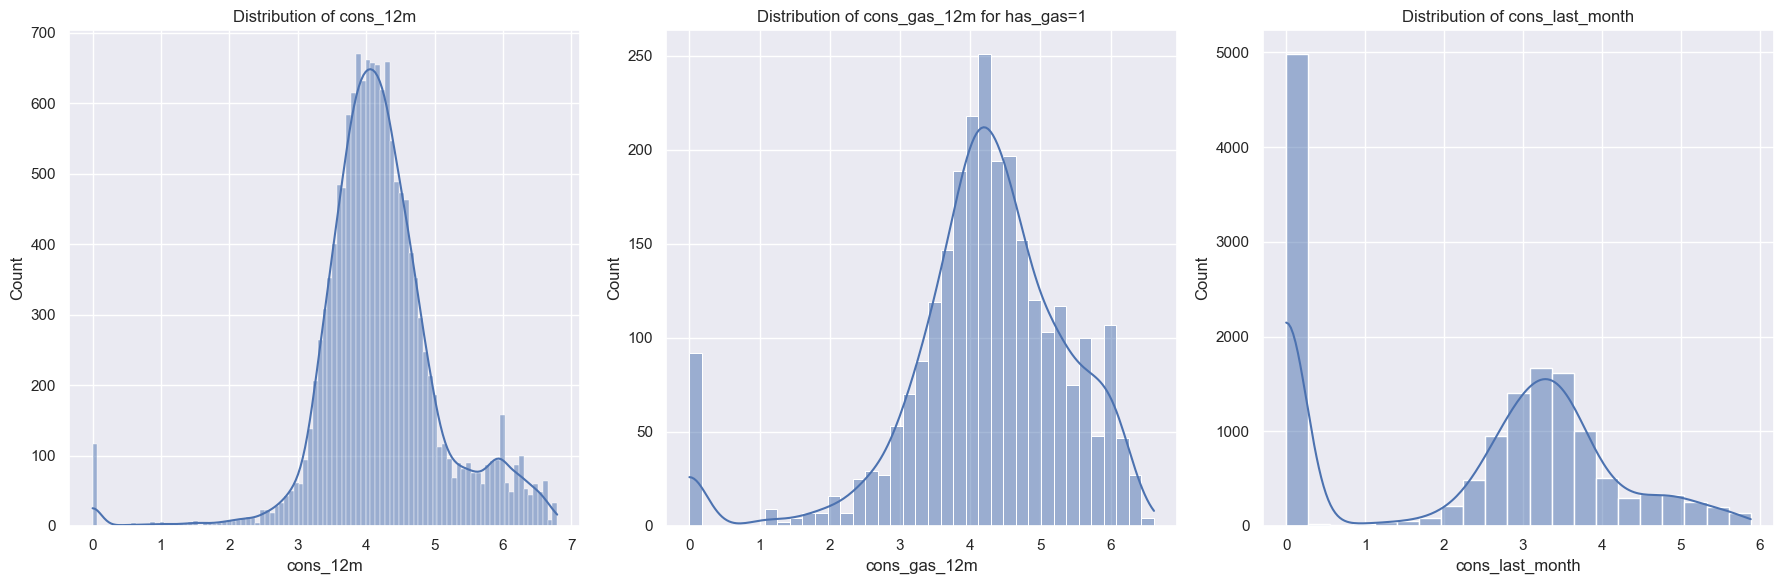

In [54]:

fig, axs = plt.subplots(1, 3, figsize=(18, 6))


sns.histplot(df["cons_12m"].dropna(), ax=axs[0], kde=True)
axs[0].set_title('Distribution of cons_12m')


sns.histplot(df[df["has_gas"] == 1]["cons_gas_12m"].dropna(), ax=axs[1], kde=True)
axs[1].set_title('Distribution of cons_gas_12m for has_gas=1')


sns.histplot(df["cons_last_month"].dropna(), ax=axs[2], kde=True)
axs[2].set_title('Distribution of cons_last_month')

plt.tight_layout()
plt.show()

### 9. Correlation

To find out how independent features are correlated to each other and the target variable

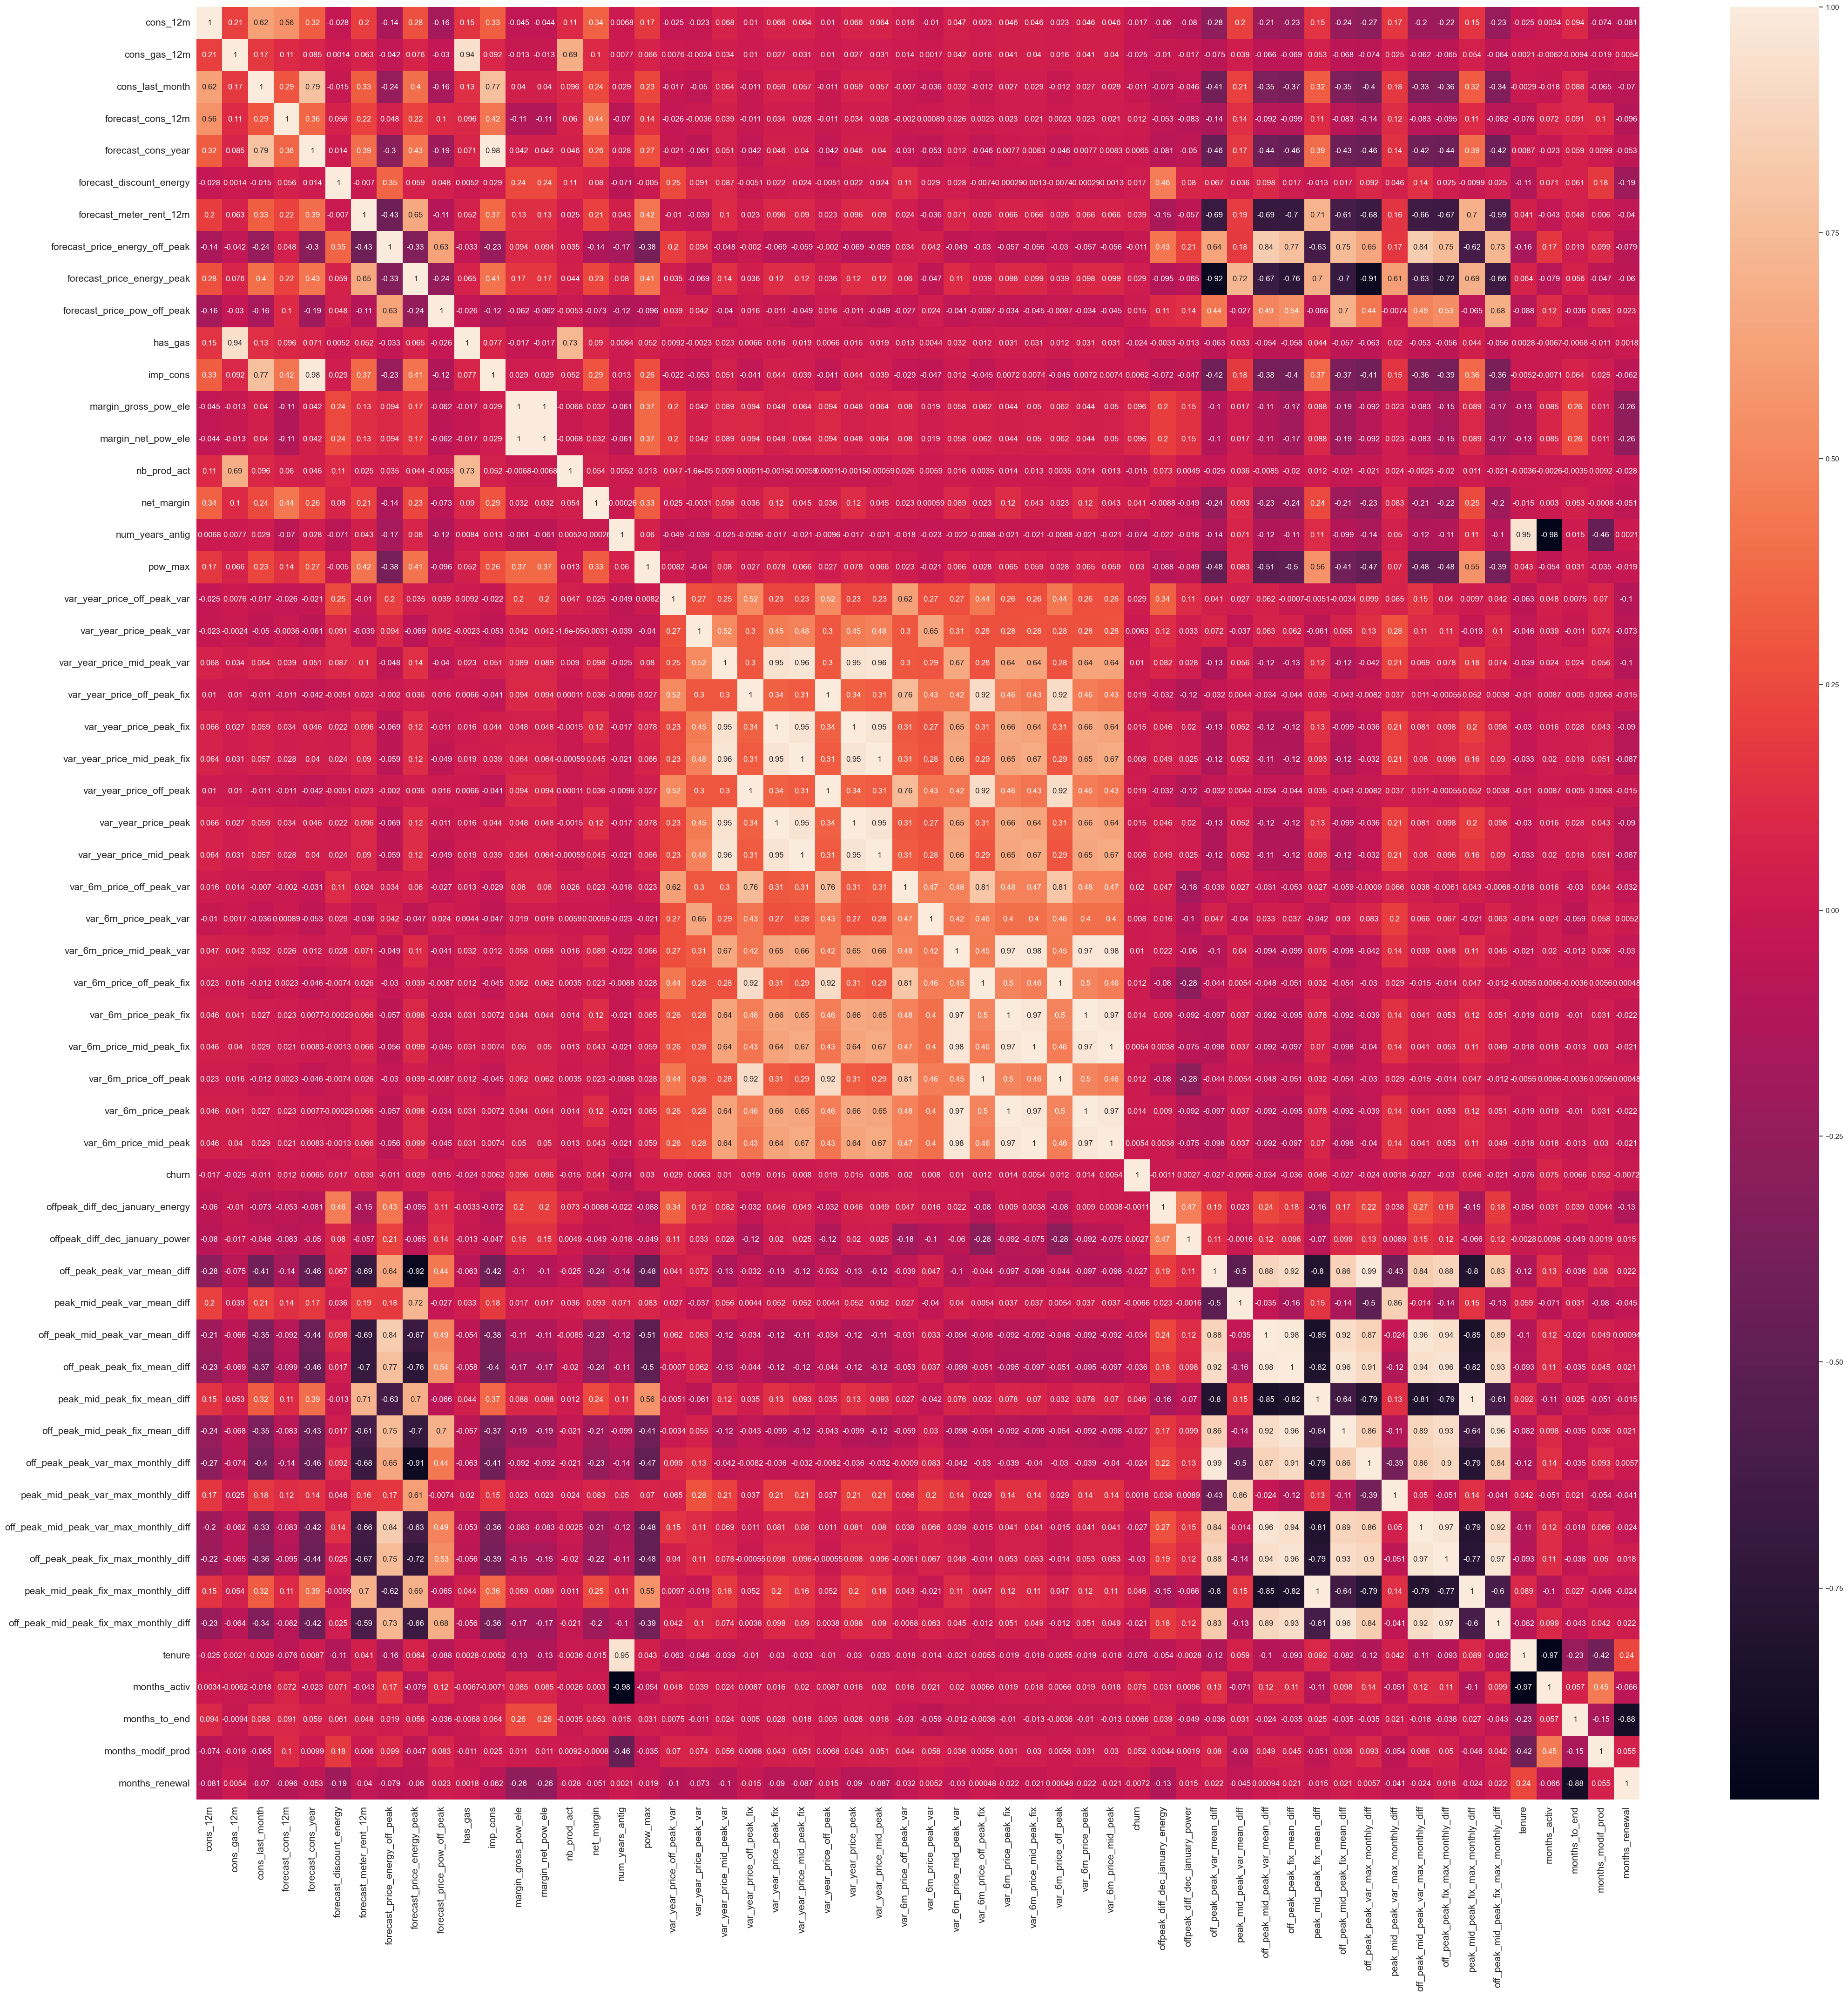

In [58]:
numeric_df = df.select_dtypes(include=[np.number])
correlation = numeric_df.corr()
plt.figure(figsize=(50, 50))
sns.heatmap(
    correlation, 
    xticklabels=correlation.columns.values,
    yticklabels=correlation.columns.values, 
    annot=True, 
    annot_kws={'size': 12}
)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

Removing independent features that are highly correlated to other independent features 

In [59]:
df = df.drop(columns=['num_years_antig', 'forecast_cons_year'])
df.head()

,id,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,...,months_modif_prod,months_renewal,channel_MISSING,channel_ewpakwlliwisiwduibdlfmalxowmwpci,channel_foosdfpfkusacimwkcsosbicdxkicaua,channel_lmkebamcaaclubfxadlmueccxoimlema,channel_usilxuppasemubllopkaafesmlibmsdf,origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws,origin_up_ldkssxwpmemidmecebumciepifcamkci,origin_up_lxidpiddsbxsbosboudacockeimpuepw
0,24011ae4ebbe3035111d65fa7c15bc57,0.000000,4.739944,0.000000,0.000000,0.0,0.444045,0.114481,0.098142,40.606701,...,-2,-6,False,False,True,False,False,False,False,True
1,d29c2c54acc38ff3c0614d0a653813dd,3.668479,0.000000,0.000000,2.280920,0.0,1.237292,0.145711,0.000000,44.311378,...,-76,-4,True,False,False,False,False,True,False,False
2,764c75f661154dac3a6c254cd082ea7d,2.736397,0.000000,0.000000,1.689841,0.0,1.599009,0.165794,0.087899,44.311378,...,-68,-8,False,False,True,False,False,True,False,False
3,bba03439a292a1e166f80264c16191cb,3.200029,0.000000,0.000000,2.382089,0.0,1.318689,0.146694,0.000000,44.311378,...,-69,-9,False,False,False,True,False,True,False,False
4,149d57cf92fc41cf94415803a877cb4b,3.646011,0.000000,2.721811,2.650065,0.0,2.122969,0.116900,0.100015,40.606701,...,-71,-9,True,False,False,False,False,True,False,False
